# mcDETECT Tutorial

Authors: Chenyang Yuan, Krupa Patel, Hongshun Shi, Hsiao-Lin V. Wang, Feng Wang, Ronghua Li, Yangping Li, Victor G. Corces, Hailing Shi, Sulagna Das, Jindan Yu, Peng Jin, Bing Yao* and Jian Hu*

### Outline

1. [Installation](#1-installation)
2. [Import Python modules](#2-import-python-modules)
3. [Read in data](#3-read-in-data)
4. [Parameter settings](#4-parameter-settings)
5. [Synapse detection](#5-synapse-detection)
6. [Spatial domain assignment](#6-spatial-domain-assignment)
7. [Synapse transcriptome profiling](#7-synapse-transcriptome-profiling)
8. [Synapse subtyping](#8-synapse-subtyping)

### 1. Installation

The detailed installation procedure can be found in [Installation](../README.md/#installation). Here I directly install `mcDETECT` by running:

```bash
python3 -m pip install mcDETECT
```

Check the current version:

In [2]:
import mcDETECT
mcDETECT.__version__

'1.0.9'

### 2. Import Python modules

Compiling this tutorial file needs the following Python packages:

In [14]:
import anndata
import math
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import miniball
import numpy as np
import pandas as pd
import random
import scanpy as sc
import SpaGCN as spg
import torch
from mcDETECT import mcDETECT

import warnings
warnings.filterwarnings("ignore")
sc.settings.verbosity = 0

### 3. Read in data

The toy dataset used in this tutorial is part of the isocortex region from [Xenium 5K mouse brain data](https://www.10xgenomics.com/datasets/xenium-prime-fresh-frozen-mouse-brain).

`mcDETECT` requires the following input:

* Transcript file: dataframe, records gene identity and 3D spatial coordinates of each mRNA molecule

In [4]:
transcripts = pd.read_parquet("toy_data/transcripts.parquet")

We need to rename some columns of the transcript file to adapt to the input format. The input transcript file should look like:

In [5]:
transcripts = transcripts[['cell_id', 'overlaps_nucleus', 'feature_name', 'x_location', 'y_location', 'z_location']]
transcripts = transcripts.rename(columns = {"feature_name": "target", "x_location": "global_x", "y_location": "global_y", "z_location": "global_z"})
print(transcripts.head().to_string())

              cell_id  overlaps_nucleus target     global_x     global_y   global_z
163006771  fgdhmaei-1                 0   A1cf  5994.734375  2021.468750  15.125000
163006772  UNASSIGNED                 0    A2m  5763.109375  2043.625000  15.781250
163006773  UNASSIGNED                 0    A2m  5951.984375  2085.984375  16.578125
163006774  hieeideh-1                 1   Aatf  5757.593750  2163.453125  17.281250
163006775  fghnlpdi-1                 1   Aatf  5969.406250  2149.406250  17.625000


* Synaptic markers: user-defined list

In [6]:
syn_genes = ['Snap25', 'Camk2a', 'Slc17a7', 'Vamp2', 'Syp', 'Syn1', 'Dlg4', 'Gria2', 'Gap43', 'Gria1', 'Bsn', 'Slc32a1']

* (Optional) Negative control markers: user-defined list. If `None`, negative control filtering will be disabled.

In [7]:
nc_genes = pd.read_csv('toy_data/negative_controls.csv')
nc_genes = list(nc_genes['Gene'])
print(nc_genes[:10])

['Neat1', 'Robo3', 'Sec1', 'Syne4', 'Xist', 'Thpo', 'Spaca6', 'Trmt13', 'Fbxl12', 'Cenpa']


### 4. Parameter settings

Instantiating an object `mc` from `mcDETECT`:

In [8]:
mc = mcDETECT(type = "Xenium", transcripts = transcripts, syn_genes = syn_genes, nc_genes = nc_genes, eps = 1.5,
              minspl = None, grid_len = 1, cutoff_prob = 0.95, alpha = 5, low_bound = 3, size_thr = 5,
              in_nucleus_thr = (0.5, 0.5), l = 1, rho = 0.2, s = 1, nc_top = 20, nc_thr = 0.1)

Hyperparameters in `mcDETECT`:
* `eps` $\epsilon$: numeric, searching radius in density-based clustering, default is 1.5 $\mu m$
* `minspl`: integer, min_samples in density-based clustering, default is `None`. Users can manually define `minspl` and thus disable the automatic parameter selection process.
* `grid_len`: numeric, side length of square grids over the tissue region (used in calculating the tissue area), default is 1 $\mu m$
* `cutoff_prob`: numeric, cutoff probability in parameter selection for min_samples, default is 0.95
* `alpha` $\alpha$: numeric, enhancing factor in parameter selection for min_samples, default is 5
* `low_bound`: integer, lower bound in parameter selection for min_samples, default is 3
* `size_thr`: numeric, threshold for maximum radius of an aggregation, default is 5 $\mu m$
* `in_nucleus_thr`: 2-d tuple, thresholds for low- and high-in-nucleus ratio, default is (0.5, 0.5)
* `l`: numeric, scaling factor for seaching overlapped spheres, default is 1
* `rho` $\rho$: numeric, threshold for determining overlaps, default is 0.2
* `s`: numeric, scaling factor for merging overlapped spheres, default is 1
* `nc_top`: integer, number of negative controls retained for filtering, default is 20
* `nc_thr`: numeric, threshold for negative control filtering, default is 0.1

### 5. Synapse detection

Synapse detection is implemented in the `detect()` function:

In [9]:
synapses = mc.detect()

1 out of 12 genes processed!
2 out of 12 genes processed!
3 out of 12 genes processed!
4 out of 12 genes processed!
5 out of 12 genes processed!
6 out of 12 genes processed!
7 out of 12 genes processed!
8 out of 12 genes processed!
9 out of 12 genes processed!
10 out of 12 genes processed!
11 out of 12 genes processed!
12 out of 12 genes processed!
Merging spheres...
Negative control filtering...


The output is a dataframe of synapse metspots:

In [10]:
print(synapses.head().to_string())

      sphere_x     sphere_y   sphere_z    layer_z  sphere_r  size  comp  in_nucleus    gene
0  5861.525313  2021.429797  15.259961  15.259961  1.115372     8     3         0.0  Snap25
1  5823.012341  2477.027071  18.744452  18.744452  1.400544    13     5         0.0  Snap25
2  5805.578936  2419.213116  18.711572  18.711572  1.355859     9     3         0.0  Snap25
3  5831.996698  2545.542771  18.262820  18.262820  1.168398     7     2         0.0  Snap25
4  5800.522809  2731.226949  16.212029  16.212029  1.322234     7     2         0.0  Snap25


* `sphere_x`, `sphere_y`, `sphere_z`: 3D spatial coordinates of each identified synapse
* `layer_z`: the nearest z-layer of each identified synapse, only applicable in iST datasets with discrete z-coordinates, e.g., MERSCOPE and CosMx
* `sphere_r`: radius of each identified synapse
* `size`: number of synaptic mRNAs within each synapse
* `comp`: number of synaptic genes presented in each synapse
* `in_nucleus`: proportion of synaptic mRNAs located within cell nuclei
* `gene`: primary synaptic marker that defines the associated synapse

### 6. Spatial domain assignment

To detect spatial domains, we first need to create a spot-level gene expression data from the transcript file. Here we only retain the top 1,000 highly variable genes and use the `spot_expression()` function to construct such data:

In [16]:
highly_variable_genes = pd.read_csv('toy_data/highly_variable_genes.csv')
highly_variable_genes = list(highly_variable_genes.iloc[:, 0])

spots = mc.spot_expression(grid_len = 50, genes = highly_variable_genes)

0 out of 1000 genes profiled!
100 out of 1000 genes profiled!
200 out of 1000 genes profiled!
300 out of 1000 genes profiled!
400 out of 1000 genes profiled!
500 out of 1000 genes profiled!
600 out of 1000 genes profiled!
700 out of 1000 genes profiled!
800 out of 1000 genes profiled!
900 out of 1000 genes profiled!


* `grid_len`: numeric, side length of square grids over the tissue region, default is 50 $\mu m$

In [17]:
spots

AnnData object with n_obs × n_vars = 400 × 1000
    obs: 'spot_id', 'global_x', 'global_y'
    var: 'genes'

Next, we apply [`SpaGCN`](https://github.com/jianhuupenn/SpaGCN/) on this spot-level gene expression data for spatial domain detection:

In [18]:
%%capture

# Spot coordinates
x_array = spots.obs['global_x'].tolist()
y_array = spots.obs['global_y'].tolist()

# Adjacency matrix
s = 1
b = 49
adj = spg.calculate_adj_matrix(x = x_array, y = y_array, histology = False)

# Pre-processing
spots.var_names_make_unique()
spg.prefilter_genes(spots, min_cells = 3)
spg.prefilter_specialgenes(spots)
sc.pp.normalize_total(spots, target_sum = 1e4)
sc.pp.log1p(spots)

# Set hyperparameters
p = 0.5
l = spg.search_l(p, adj, start = 0.01, end = 1000, tol = 0.01, max_run = 100)

n_clusters = 6
r_seed = t_seed = n_seed = 1
res = spg.search_res(spots, adj, l, n_clusters, start = 0.7, step = 0.1, tol = 5e-3, lr = 0.05, max_epochs = 20, r_seed = r_seed, t_seed = t_seed, n_seed = n_seed)

# Run SpaGCN
clf = spg.SpaGCN()
clf.set_l(l)

random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)

clf.train(spots, adj, init_spa = True, init = "louvain", res = res, tol = 5e-3, lr = 0.05, max_epochs = 200)
y_pred, prob = clf.predict()
spots.obs["pred"] = y_pred
spots.obs["pred"] = spots.obs["pred"].astype('category')

adj_2d = spg.calculate_adj_matrix(x = x_array, y = y_array, histology = False)
refined_pred = spg.refine(sample_id = spots.obs.index.tolist(), pred = spots.obs["pred"].tolist(), dis = adj_2d, shape = "square")
spots.obs["refined_pred"] = refined_pred
spots.obs["refined_pred"] = spots.obs["refined_pred"].astype('category')

The spot-level spatial domain assignment looks like:

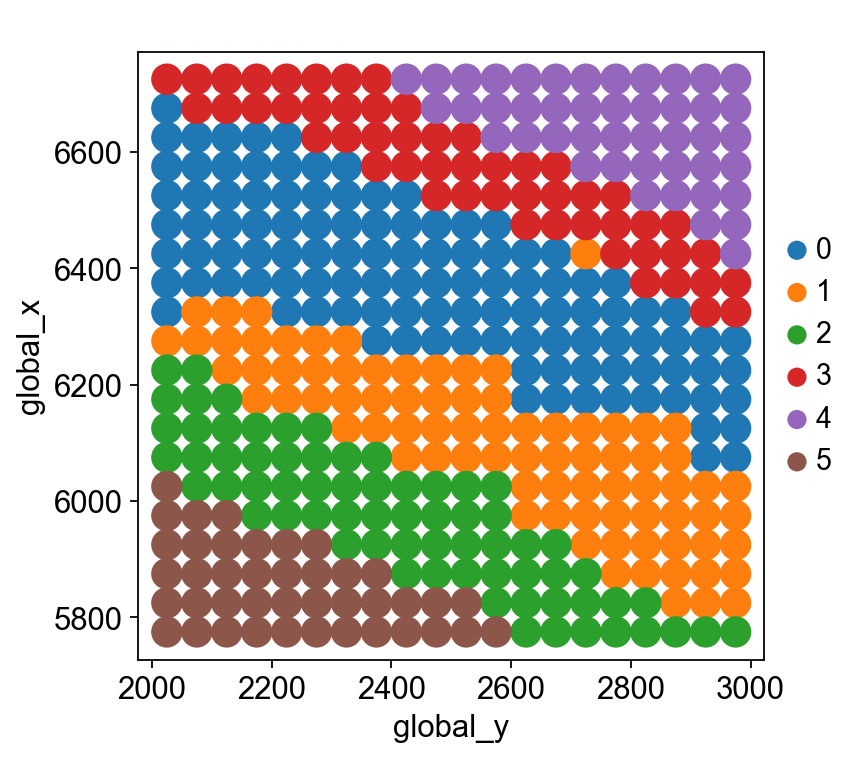

In [30]:
# plot spatial domains
sc.set_figure_params(scanpy = True, figsize = (5, 5))
ax = sc.pl.scatter(spots, alpha = 1, x = "global_y", y = "global_x", color = "refined_pred", title = " ", show = False, size = 800)
ax.grid(False)
plt.show()

### 7. Synapse transcriptome profiling

In [ ]:
a = mc.profile(sphere)

### 8. Synapse subtyping